In [1]:
!pwd

/Users/yuanshi/Library/CloudStorage/Box-Box/Sequence Analysis/2025/D1D2_organize/script_DNA


In [2]:
import pickle, json, os, hashlib
import pandas as pd
from statannotations.Annotator import Annotator
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# load data
1. perIS
2. perBC
3. summary

In [3]:
summary = pd.read_csv('../csvfiles/summary_lite.csv')
perIS = pd.read_csv('../csvfiles/perIS_lite.csv')
perBC = pd.read_csv('../csvfiles/perBC_lite.csv')

treatment_order = ['No NK', 'GFP-NK', 'D1D2-NK']
summary['Treatment'] = pd.Categorical(summary['Treatment'], categories=treatment_order, ordered=True)

In [4]:
with open('../jsonfiles/notebook3_output.json','r') as f:
    file_md5 = json.load(f)

In [5]:
#check md5 and store
def get_file_md5(file_path):
    md5_hash = hashlib.md5()
    with open(file_path, "rb") as file:
        for chunk in iter(lambda: file.read(4096), b""):
            md5_hash.update(chunk)
    return md5_hash.hexdigest()

def store_md5_in_json(file_paths, json_output):
    md5_dict = {}
    for file_path in file_paths:
        md5_hash = get_file_md5(file_path)
        md5_dict[file_path] = md5_hash

    with open(json_output, "w") as json_file:
        json.dump(md5_dict, json_file, indent=4)

In [6]:
for k,v in file_md5.items():
    print (os.path.basename(k),end='\t')
    if get_file_md5(k) == v:
        print ('Confirmed')
    else:
        print ('File mismatch')

perIS_lite.csv	Confirmed
perBC_lite.csv	Confirmed
summary_lite.csv	Confirmed


# Move Database files here

In [7]:
original_path = '../../../2024/IS paper_031124/'

need the following files
1. for gene intersection: `hg38_Ensembl_genes.gff3` from `genome_annotation`
2. for gene distance mapping: sorting: `hg38.chrom.sizes` from `genome_annotation`
3. for gene distance mapping: `hg38_Ensembl_genes_sorted.bed` from `genome_annotation`
4. for regulatory element intersection: `hg38_Ensembl_release108_Regulatory_activity_CD4_ab.gff` from `genome_annotation`
5. for histone distance mapping: `Tcell_{histone}.sort.bed` from `bed`

In [8]:
import shutil, glob

src_md5 = dict()
dst_md5 = dict()

files = ['hg38_Ensembl_genes.gff3','hg38.chrom.sizes','hg38_Ensembl_genes_sorted.bed','hg38_Ensembl_release108_Regulatory_activity_CD4_ab.gff']

for f in files:
    fn = os.path.basename(f)
    src = os.path.join(original_path,'genome_annotation',f)
    dst = "../database/{}".format(f)
    src_md5[fn] = get_file_md5(src)
    shutil.copy(src, dst)   # copies file contents + permissions

files = glob.glob(f'{original_path}bed/Tcell_H*sort.bed')

for f in files:
    fn = os.path.basename(f)
    src_md5[fn] = get_file_md5(f)
    shutil.copy(f,"../database/{}".format(fn))

with open('../jsonfiles/database_source.json','w') as f:
    json.dump(src_md5,f)

for fn in src_md5:
    m = get_file_md5(f'../database/{fn}')
    if m == src_md5[fn]:
        dst_md5[fn] = m
    else:
        print (f"file corruption: {fn}")

with open('../jsonfiles/database_dst.json','w') as f:
    json.dump(src_md5,f)

In [9]:
dst_md5

{'hg38_Ensembl_genes.gff3': '7da619fbf5d840ba717abae3361cc9f1',
 'hg38.chrom.sizes': '0b7d0bd56f5a3eb6d380e64ce4809e53',
 'hg38_Ensembl_genes_sorted.bed': '8ca7bd8c057b619c90779647664222c9',
 'hg38_Ensembl_release108_Regulatory_activity_CD4_ab.gff': 'aaa21f2aeebd39f6a1aa24ca3e0c4439',
 'Tcell_H3K36me3.sort.bed': '2390bf1e545ac9cfe41de9726993f90a',
 'Tcell_H3K27ac.sort.bed': '69bdc71e94f06cf3721c52339eaad680',
 'Tcell_H3K4me1.sort.bed': 'e33d97d83e846c6ed59b97f55086318a',
 'Tcell_H3K9me3.sort.bed': '40018633a19fe2eebce89bfde66b7913',
 'Tcell_H3K27me3.sort.bed': '1406924a08862f2426fd4496d6ba2046',
 'Tcell_H3K4me3.sort.bed': '376d59398532fe1d88d2c3b1e2a17aca'}

# Gene and Regulatory Elements Association

## make bedfile
perIS.bed

In [10]:
perIS_col = list(perIS.columns)

bed_cols = ['chrom','pos','pos1','strand'] + perIS_col
with open('../bedfiles/perIS.bed','w') as f:
    for i,row in perIS.iterrows():
        if 'chr' in row['site']:
            record = row['site'].rsplit(':')
            cols = [record[0][3:],record[1],record[1],record[2]] #chrom, start, end, strand
            for field in perIS_col:
                cols.append(str(row[field]))
            f.write('\t'.join(cols))
            f.write('\n')

## intersect with gene


The gff3 file for gene is called "../database/hg38_Ensembl_genes.gff3". </br>
The `bedtools` command for identify if an IS is in a gene (and what kind of gene) or in a regulatory element is this: `!bedtools intersect -wb -a {perIS bedfile} -b {database gff file} > {output bedfile}`

Take a look at the gff files, to make sure the column is what I thought they are

```
!head -1 ../database/hg38_Ensembl_genes.gff3 | awk -F'\t' '{for (i=1;i<=NF;i++) print "Column " i ": " $i}'
!head -1 ../database/hg38_Ensembl_release108_Regulatory_activity_CD4_ab.gff | awk -F'\t' '{for (i=1;i<=NF;i++) print "Column " i ": " $i}'
```

The header seems to be `'chrom2','source','type','start','end','score','strand2','phase','attributes'`

In [11]:
!bedtools intersect -wb -a ../bedfiles/perIS.bed -b ../database/hg38_Ensembl_genes.gff3 > ../bedfiles/perIS_genes.bed

In [12]:
gff3_col = ['chrom2','source','type','start','end','score','strand2','phase','attributes']

### Analyze Genes
1. load from the file `../bedfiles/perIS_genes.bed`
2. parse information based on "attributes"
3. generate a `multiple genes` field
4. pick the top gene based on likelihood of transcription
5. merge with IS

In [13]:
# analyze genes
import re

def parse_attr(attribute):
    search = re.search(r';biotype=(.*?);',attribute)
    biotype = search.group(1) if search else ''
    search = re.search(r';gene_id=(.*?);',attribute)
    ENSG = search.group(1) if search else ''
    search = re.search(r';Name=(.*?);',attribute)
    gene = search.group(1) if search else ENSG
    return biotype,ENSG,gene


interdata = pd.read_csv(f'../bedfiles/perIS_genes.bed',sep='\t',names=bed_cols+gff3_col)
interdata['Gene_Name'] = interdata['attributes'].apply(lambda x: parse_attr(x)[2])
interdata['ENSG'] = interdata['attributes'].apply(lambda x: parse_attr(x)[1])
interdata['Gene_Type'] = interdata['attributes'].apply(lambda x: parse_attr(x)[0])

In [14]:
# get multiple genes attribute
multiple = interdata.groupby(bed_cols).count()[['chrom2']]
multiple.columns = ['multiple genes']
multiple = multiple.reset_index()
interdata = pd.merge(interdata,multiple,left_on=bed_cols,right_on=bed_cols)

In [15]:
interdata[['type','Gene_Type']].drop_duplicates()

,type,Gene_Type
0,gene,protein_coding
3,ncRNA_gene,lncRNA
50,pseudogene,transcribed_processed_pseudogene
105,pseudogene,transcribed_unprocessed_pseudogene
231,pseudogene,processed_pseudogene
550,gene,TEC
682,ncRNA_gene,misc_RNA
706,pseudogene,unprocessed_pseudogene
783,pseudogene,transcribed_unitary_pseudogene
3421,pseudogene,unitary_pseudogene


In [16]:
#rank order, the most likely to be transcribe to the least. Filter base on the rank if multiple gene is mapped
rank_map = {
    'protein_coding': 1,
    
    'TR_V_gene': 2,
    'TR_C_gene': 2,
    'IG_V_gene': 2,
    
    'lncRNA': 3,
    'ncRNA_gene': 3,   # fallback label
    'snRNA': 3,
    'snoRNA': 3,
    
    'miRNA': 4,
    'misc_RNA': 4,
    'rRNA': 4,
    
    'transcribed_processed_pseudogene': 5,
    'transcribed_unprocessed_pseudogene': 5,
    'transcribed_unitary_pseudogene': 5,
    
    'processed_pseudogene': 6,
    'unprocessed_pseudogene': 6,
    'unitary_pseudogene': 6,
    'rRNA_pseudogene': 6,
    
    'TEC': 7,
    'pseudogene': 7,   # generic fallback
    '': 7              # empty/unknown
}

interdata['rank'] = interdata['Gene_Type'].map(rank_map)
interdata = interdata.sort_values('rank').reset_index(drop=True)
interdata = interdata.drop_duplicates(perIS_col)

In [17]:
# only columns worth saving are perIS_col and the last five new inferred fields
fields = ['type','Gene_Name', 'ENSG', 'Gene_Type', 'multiple genes']
interdata = interdata[perIS_col+fields]

In [18]:
perIS = pd.merge(interdata,perIS,left_on=perIS_col,right_on=perIS_col,how='outer')

In [19]:
perIS.columns

Index(['site', 'SampleID', 'Mouse_Cohort', 'MouseID', 'AnimalID', 'Organ',
       'Treatment', 'UMI', 'barcode', 'Proliferation', 'Transcription_Organ',
       'Transcription_Animal', 'Transcription_TB', 'Viremia', 'type',
       'Gene_Name', 'ENSG', 'Gene_Type', 'multiple genes'],
      dtype='object')

In [20]:
perIS['In_Gene'] = perIS['type'].isin(['gene'])
perIS = perIS.drop(columns=["type"])

## Intersect and analyze regulatory elements
Also prepare the gff3 file here to be used later

In [21]:
reguref = pd.read_csv('../database/hg38_Ensembl_release108_Regulatory_activity_CD4_ab.gff',sep='\t',comment='#',names=['seqid','source','type','start','end','score','strand','phase','attributes'])
reguref = reguref[reguref['seqid'].apply(lambda x: True if x in [str(x) for x in list(range(1,23))]+['X','Y'] else False)]

In [22]:
regulist = list(set(reguref['type']))
for element in regulist:
    tdata = reguref[reguref['type']==element]
    tdata.to_csv('../database/regu_'+element+'.gff3',index=False,header=False,sep='\t')
    !bedtools intersect -a ../bedfiles/perIS.bed -b ../database/regu_{element}.gff3 > ../bedfiles/perIS_{element}.bed

In [23]:
for element in regulist:
    interdata = pd.read_csv('../bedfiles/perIS_{}.bed'.format(element),names = bed_cols,sep='\t')[perIS_col]
    interdata = interdata.drop_duplicates()
    interdata['type'] = element
    perIS = pd.merge(perIS,interdata,left_on=list(perIS_col),right_on=list(perIS_col),how='outer')
    perIS['In_{}'.format(element)] = ~perIS['type'].isna()
    perIS = perIS.drop(columns='type')

In [24]:
perIS.to_csv('../csvfiles/perIS_intersect.csv',index=False)

In [25]:
filelists = ['../csvfiles/perIS_intersect.csv']
variables = {'original_path':original_path, 'perIS_col':perIS_col, 'bed_cols':bed_cols,'gff3_col':gff3_col,'rank_map':rank_map,'regulist':regulist}

# Distance to Gene and Regulatory Elements

## Prepare files

In [26]:
chroms = set()
with open("../database/hg38.chrom.sizes") as f:
    for line in f.readlines():
        chroms.add(line.strip().split('\t')[0])

with open('../bedfiles/perIS_distance.bed','w') as f:
    for i,row in perIS.iterrows():
        chrom = row['site'].split(':')[0]
        if chrom.startswith('chr') and chrom[3:] in chroms:
            record = row['site'].rsplit(':')
            cols = [record[0][3:],record[1],record[1],record[2]] #chrom, start, end, strand
            for field in perIS_col:
                cols.append(str(row[field]))
            f.write('\t'.join(cols))
            f.write('\n')

## Gene Distance

In [27]:
!bedtools closest -d -a ../bedfiles/perIS_sorted.bed -b ../database/hg38_Ensembl_genes_sorted.bed -g ../database/hg38.chrom.sizes > ../bedfiles/perIS_distance_to_gene.bed

In [28]:
sorted_bed_col = ['chrom2','pos2','pos21','attributes','score2','strand2','distance'] #directly from TH's code

In [29]:
closedata = pd.read_csv('../bedfiles/perIS_distance_to_gene.bed',sep='\t',names=bed_cols+sorted_bed_col)

In [30]:
closedata

,chrom,pos,pos1,strand,site,SampleID,Mouse_Cohort,MouseID,AnimalID,Organ,...,Transcription_Animal,Transcription_TB,Viremia,chrom2,pos2,pos21,attributes,score2,strand2,distance
0,1,896730,896730,+,chr1:896730:+,JCMMG32-#54-SP,JCMMG32,#54,JCMMG32-#54,SP,...,0.115768,0.121662,True,1,904834,915976,ID=gene:ENSG00000272438;biotype=lncRNA;descrip...,.,+,8104
1,1,923293,923293,+,chr1:923293:+,JCMMG32.1-#2-SP,JCMMG32.1,#2,JCMMG32.1-#2,SP,...,0.000000,0.000000,False,1,923923,944575,ID=gene:ENSG00000187634;Name=SAMD11;biotype=pr...,.,+,630
2,1,958696,958696,-,chr1:958696:-,JMGA36-#6-BM,JMGA36,#6,JMGA36-#6,BM,...,0.645885,0.823817,True,1,944203,959309,ID=gene:ENSG00000188976;Name=NOC2L;biotype=pro...,.,-,0
3,1,1054476,1054476,+,chr1:1054476:+,JMGA36-#12-BM,JMGA36,#12,JMGA36-#12,BM,...,0.110825,0.067542,True,1,1020120,1056118,ID=gene:ENSG00000188157;Name=AGRN;biotype=prot...,.,+,0
4,1,1270722,1270722,-,chr1:1270722:-,JCMMG32.1-#2-SP,JCMMG32.1,#2,JCMMG32.1-#2,SP,...,0.000000,0.000000,False,1,1253909,1273864,ID=gene:ENSG00000160087;Name=UBE2J2;biotype=pr...,.,-,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7980,M,9094,9094,-,chrM:9094:-,JCMMG32.1-#2-SP,JCMMG32.1,#2,JCMMG32.1-#2,SP,...,0.000000,0.000000,False,M,8527,9207,ID=gene:ENSG00000198899;Name=MT-ATP6;biotype=p...,.,+,0
7981,M,9110,9110,+,chrM:9110:+,JCMMG32-#54-BM,JCMMG32,#54,JCMMG32-#54,BM,...,0.056898,0.020772,True,M,8527,9207,ID=gene:ENSG00000198899;Name=MT-ATP6;biotype=p...,.,+,0
7982,M,13142,13142,+,chrM:13142:+,JMGA36-#12-BM,JMGA36,#12,JMGA36-#12,BM,...,0.738711,0.851782,True,M,12337,14148,ID=gene:ENSG00000198786;Name=MT-ND5;biotype=pr...,.,+,0
7983,Un_KI270412v1,340,340,-,chrUn_KI270412v1:340:-,JCMMG32-#32-BM,JCMMG32,#32,JCMMG32-#32,BM,...,0.000000,0.000000,False,.,-1,-1,.,-1,.,-1


In [31]:
closedata['Gene_Name'] = closedata['attributes'].apply(lambda x: parse_attr(x)[2])
closedata['ENSG'] = closedata['attributes'].apply(lambda x: parse_attr(x)[1])
closedata['Gene_Type'] = closedata['attributes'].apply(lambda x: parse_attr(x)[0])

In [32]:
len(closedata)

7985

In [33]:
closedata.columns

Index(['chrom', 'pos', 'pos1', 'strand', 'site', 'SampleID', 'Mouse_Cohort',
       'MouseID', 'AnimalID', 'Organ', 'Treatment', 'UMI', 'barcode',
       'Proliferation', 'Transcription_Organ', 'Transcription_Animal',
       'Transcription_TB', 'Viremia', 'chrom2', 'pos2', 'pos21', 'attributes',
       'score2', 'strand2', 'distance', 'Gene_Name', 'ENSG', 'Gene_Type'],
      dtype='object')

In [35]:
multiple = closedata.groupby(bed_cols).count()[['chrom2']]
multiple.columns = ['multiple genes']
multiple = multiple.reset_index()

In [36]:
closedata = pd.merge(multiple,closedata,left_on=bed_cols,right_on=bed_cols)

In [37]:
closedata['Gene_Type'].unique()

array(['lncRNA', 'protein_coding', 'transcribed_processed_pseudogene',
       'snRNA', 'processed_pseudogene', 'miRNA',
       'transcribed_unprocessed_pseudogene', 'unprocessed_pseudogene',
       'TEC', 'misc_RNA', 'snoRNA', 'rRNA_pseudogene', '',
       'transcribed_unitary_pseudogene', 'rRNA', 'TR_V_gene', 'TR_C_gene',
       'unitary_pseudogene', 'IG_V_gene'], dtype=object)

In [38]:
closedata['rank'] = closedata['Gene_Type'].map(rank_map)
closedata = closedata.sort_values('rank').reset_index(drop=True)

In [39]:
closedata = closedata.drop_duplicates(perIS_col)

In [40]:
len(closedata)

7266

In [41]:
closedata.columns

Index(['chrom', 'pos', 'pos1', 'strand', 'site', 'SampleID', 'Mouse_Cohort',
       'MouseID', 'AnimalID', 'Organ', 'Treatment', 'UMI', 'barcode',
       'Proliferation', 'Transcription_Organ', 'Transcription_Animal',
       'Transcription_TB', 'Viremia', 'multiple genes', 'chrom2', 'pos2',
       'pos21', 'attributes', 'score2', 'strand2', 'distance', 'Gene_Name',
       'ENSG', 'Gene_Type', 'rank'],
      dtype='object')

In [42]:
#fields = ['Gene_Name', 'ENSG', 'Gene_Type', 'multiple genes','distance']

## merge to perIS

In [43]:
# reload, perIS roll back to the original one
perIS = pd.read_csv('../csvfiles/perIS_lite.csv')
len(closedata)

len(perIS),len(closedata)

(7275, 7266)

In [44]:
perIS = pd.merge(perIS,closedata,left_on=perIS_col,right_on=perIS_col,how='outer')

In [45]:
perIS.columns

Index(['site', 'SampleID', 'Mouse_Cohort', 'MouseID', 'AnimalID', 'Organ',
       'Treatment', 'UMI', 'barcode', 'Proliferation', 'Transcription_Organ',
       'Transcription_Animal', 'Transcription_TB', 'Viremia', 'chrom', 'pos',
       'pos1', 'strand', 'multiple genes', 'chrom2', 'pos2', 'pos21',
       'attributes', 'score2', 'strand2', 'distance', 'Gene_Name', 'ENSG',
       'Gene_Type', 'rank'],
      dtype='object')

In [46]:
tlist = perIS_col + ['multiple genes','Gene_Name', 'ENSG', 'Gene_Type','distance']

In [47]:
perIS = perIS[tlist]

In [48]:
perIS = perIS.rename(columns={'distance': 'distance_gene'})

## Distance to other regulatory elements

In [49]:
oddsdict = {}
pdict = {}
for element in regulist:
    print(element)
    !bedtools sort -i ../database/regu_{element}.gff3 -g ../database/hg38.chrom.sizes > ../database/regu_{element}.sort.gff3
    !bedtools fisher -a ../bedfiles/perIS_sorted.bed -b ../database/regu_{element}.sort.gff3 -g ../database/hg38.chrom.sizes > ../bedfiles/fisher_{element}.tsv
    rdata = pd.read_csv('../bedfiles/fisher_'+element+'.tsv',sep='\t',comment='#')
    oddsdict[element] = rdata.iloc[0]['ratio']
    pdict[element] = rdata.iloc[0]['two-tail']

open_chromatin_region
promoter
CTCF_binding_site
TF_binding_site
enhancer


In [50]:
for element in regulist:
    !bedtools closest -D b -a ../bedfiles/perIS_sorted.bed -b ../database/regu_{element}.sort.gff3 > ../bedfiles/perIS_{element}.bed

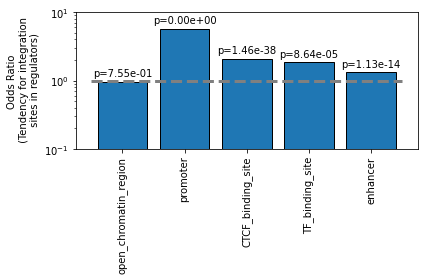

In [51]:
plt.figure(figsize=(6,4))
plt.bar(x=list(oddsdict.keys()),height=list(oddsdict.values()),edgecolor='black')
plt.yscale('log')
plt.xticks(rotation=90)
plt.ylim(0.1,10)
plt.hlines(y=1,xmin=-0.5,xmax=len(oddsdict)-0.5,color='grey',linewidth=3,linestyle='--')
plt.ylabel('Odds Ratio\n (Tendency for integration\n sites in regulators)')
for i,v in enumerate(pdict.values()):
    plt.text(i,list(oddsdict.values())[i]*1.2,'p={:0.2e}'.format(v),ha='center')
plt.tight_layout()

In [52]:
for element in regulist:
    #print (len(perIS),end='\t')
    names = ['chrom','pos','pos1','strand1']+perIS_col+['chrom2','source','type','start','end','score','strand2','phase','attributes','distance_{}'.format(element)]
    df = pd.read_csv('../bedfiles/perIS_{}.bed'.format(element),sep='\t',names=names)
    df = df.groupby(list(perIS_col))[['distance_{}'.format(element)]].first().reset_index()
    #print (len(df))
    perIS = pd.merge(perIS,df,left_on=list(perIS_col),right_on=list(perIS_col),how='outer')
    #print (element,len(perIS),len(df))

# Histone distance

In [53]:
import re

histonelist = []
for infile in os.listdir('../database'):
    if infile.startswith ('Tcell') and infile.endswith('.sort.bed'):
        item = re.findall(r'Tcell_(H.*).sort.bed',infile)
        if item:
            histone = item[0]
            histonelist.append(histone)
            !bedtools closest -D a -a ../bedfiles/perIS_sorted.bed -b ../database/Tcell_{histone}.sort.bed -g ../database/hg38.chrom.sizes > ../bedfiles/IS_{histone}_distance.bed

In [54]:
histonelist

['H3K36me3', 'H3K27ac', 'H3K4me1', 'H3K9me3', 'H3K27me3', 'H3K4me3']

In [55]:
#perIS = pd.read_csv('../csvfiles/perIS_lite.csv')
CHIP_col = ['chr','start','end','annotation','score','strand2']
names =  ['chrom','pos','pos1','strand']+perIS_col+CHIP_col+['distance']

In [56]:
tdata.columns

Index(['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase',
       'attributes'],
      dtype='object')

In [58]:
new_perIS_col = list(perIS.columns)
for histone in histonelist:
    interdata = pd.read_csv('../bedfiles/IS_'+histone+'_distance.bed',sep='\t',names=names)
    tdata = pd.merge(perIS,interdata,left_on = perIS_col,right_on=perIS_col,how='outer')[new_perIS_col+['distance']].drop_duplicates()
    tdata.columns = new_perIS_col+['distance_{}'.format(histone)]
    perIS = tdata
    new_perIS_col = list(perIS.columns)

In [59]:
perIS.columns

Index(['site', 'SampleID', 'Mouse_Cohort', 'MouseID', 'AnimalID', 'Organ',
       'Treatment', 'UMI', 'barcode', 'Proliferation', 'Transcription_Organ',
       'Transcription_Animal', 'Transcription_TB', 'Viremia', 'multiple genes',
       'Gene_Name', 'ENSG', 'Gene_Type', 'distance_gene',
       'distance_open_chromatin_region', 'distance_promoter',
       'distance_CTCF_binding_site', 'distance_TF_binding_site',
       'distance_enhancer', 'distance_H3K36me3', 'distance_H3K27ac',
       'distance_H3K4me1', 'distance_H3K9me3', 'distance_H3K27me3',
       'distance_H3K4me3'],
      dtype='object')

In [60]:
perIS.to_csv('../csvfiles/perIS_distance.csv',index=False)

In [61]:
filelists.append('../csvfiles/perIS_distance.csv')

In [65]:
variables.update({'sorted_bed_col':sorted_bed_col,'oddsdict':oddsdict,'pdict':pdict,'histonelist':histonelist,'CHIP_col':CHIP_col})

# save everything and md5

In [66]:
# bedfiles
bedpath = '../bedfiles'
files = [os.path.join(bedpath,f) for f in os.listdir(bedpath) if f.endswith('bed')]
store_md5_in_json(files,'../jsonfiles/notebook4_bedfiles.json')

In [67]:
!cat ../jsonfiles/notebook4_bedfiles.json

{
    "../bedfiles/perIS_promoter.bed": "84e579d1264d06d9b6f576c94a93fb83",
    "../bedfiles/perIS_sorted.bed": "1bbc6c2b9c53edecabceb9c8c78c191d",
    "../bedfiles/IS_H3K4me3_distance.bed": "8e19dadee53ea975b608447c1121b04f",
    "../bedfiles/perIS.bed": "d56a94999a9fcf803bb49212fd4f3fff",
    "../bedfiles/perIS_genes.bed": "d0848f69177f01365c7898e2eb5e3e2e",
    "../bedfiles/perIS_TF_binding_site.bed": "affafb4b2d1d06b3a3855d50f6597216",
    "../bedfiles/perIS_enhancer.bed": "ba6ba734a59ddcfc2c0dec11377a1377",
    "../bedfiles/IS_H3K27ac_distance.bed": "43a7eb6dc19a7bfb368cc09f330571e5",
    "../bedfiles/perIS_distance_to_gene.bed": "f4097dcc2a64131cd37c3ae3dca9e298",
    "../bedfiles/perIS_open_chromatin_region.bed": "cca0e980d481b592b020084e448194ea",
    "../bedfiles/IS_H3K4me1_distance.bed": "eaf45696ba836497467b1f56d281354a",
    "../bedfiles/IS_H3K27me3_distance.bed": "94554a02567788b5b6d7011900c0c241",
    "../bedfiles/IS_H3K9me3_distance.bed": "2d2f2d4fe4def4662c318ce8887ea17

In [68]:
# fisher tsv files
bedpath = '../bedfiles'
files = [os.path.join(bedpath,f) for f in os.listdir(bedpath) if f.endswith('tsv')]
store_md5_in_json(files,'../jsonfiles/notebook4_fisherfiles.json')

In [69]:
!cat ../jsonfiles/notebook4_fisherfiles.json

{
    "../bedfiles/fisher_enhancer.tsv": "e2df885e8a7472c677750fc80c7ec929",
    "../bedfiles/fisher_CTCF_binding_site.tsv": "ad637250822d0cc2e9e67e081ab5bf3d",
    "../bedfiles/fisher_open_chromatin_region.tsv": "c52676b18fde52bfed8551e81b56974d",
    "../bedfiles/fisher_promoter.tsv": "48cabade999b0295f73a811aa6c12d2c",
    "../bedfiles/fisher_TF_binding_site.tsv": "a81ee0e2ccd698e02405776d735f2467"
}

In [70]:
#database
dbpath = '../database'
files = [os.path.join(dbpath,f) for f in os.listdir(dbpath)]
store_md5_in_json(files,'../jsonfiles/notebook4_databasefiles.json')

In [71]:
!cat ../jsonfiles/notebook4_databasefiles.json

{
    "../database/Tcell_H3K36me3.sort.bed": "2390bf1e545ac9cfe41de9726993f90a",
    "../database/Tcell_H3K27ac.sort.bed": "69bdc71e94f06cf3721c52339eaad680",
    "../database/hg38_Ensembl_genes_sorted.bed": "8ca7bd8c057b619c90779647664222c9",
    "../database/Tcell_H3K4me1.sort.bed": "e33d97d83e846c6ed59b97f55086318a",
    "../database/regu_open_chromatin_region.gff3": "3678ae4b4e9b907011c962507499232c",
    "../database/.DS_Store": "194577a7e20bdcc7afbb718f502c134c",
    "../database/hg38_Ensembl_release108_Regulatory_activity_CD4_ab.gff": "aaa21f2aeebd39f6a1aa24ca3e0c4439",
    "../database/Tcell_H3K9me3.sort.bed": "40018633a19fe2eebce89bfde66b7913",
    "../database/hg38_Ensembl_genes.gff3": "7da619fbf5d840ba717abae3361cc9f1",
    "../database/regu_TF_binding_site.gff3": "2b06332c5a2889b51ff4b371d650414c",
    "../database/regu_TF_binding_site.sort.gff3": "94e7b5d98d2408fe51a7c250592ec201",
    "../database/regu_CTCF_binding_site.sort.gff3": "39b3dbe664a454009a47557da9ad6c70",
    

In [72]:
store_md5_in_json(filelists,'../jsonfiles/notebook4_datafiles.json')

In [78]:
!cat ../jsonfiles/notebook4_datafiles.json

{
    "../csvfiles/perIS_intersect.csv": "685ec108822ded6717a994e1fd0eb434",
    "../csvfiles/perIS_distance.csv": "d72ba984211a318e4f348b2c3589ca3d"
}

In [79]:
with open('../picklefiles/notebook5.pkl','wb') as f:
    pickle.dump(variables,f)